# XGBoost

In [1]:
import pandas as pd
import numpy as np
import joblib
import cupy as cp
import optuna
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


c:\Users\Sebastijan\anaconda3\envs\diabetes-insight\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(df):
    X = df.drop(columns=["diagnosed_diabetes"])
    y = df["diagnosed_diabetes"]

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=0.3,
        random_state=2025,
        shuffle=True
    )

    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=2025,
        shuffle=True
    )

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_valid_std = scaler.transform(X_valid)
    X_test_std = scaler.transform(X_test)

    return X_train_std, X_valid_std, X_test_std, y_train, y_valid, y_test

In [3]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import evaluate_metrics, plot_roc_curve, optimize_threshold

In [4]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(df)

In [5]:
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_valid_gpu = cp.array(X_valid)
y_valid_gpu = cp.array(y_valid)
X_test_gpu  = cp.array(X_test)
y_test_gpu  = cp.array(y_test)

We will begin with an untuned model.

In [6]:
xgb_untuned = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    device='cuda',
    early_stopping_rounds=50,
    random_state=2025
)

xgb_untuned.fit(
    X_train_gpu, y_train_gpu,
    eval_set=[(X_valid_gpu, y_valid_gpu)],
    verbose=None
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
y_train_pred = xgb_untuned.predict(X_train_gpu)
y_test_pred = xgb_untuned.predict(X_test_gpu)

y_train_true = cp.asnumpy(y_train)
y_test_true = cp.asnumpy(y_test)

Training Set Metrics:


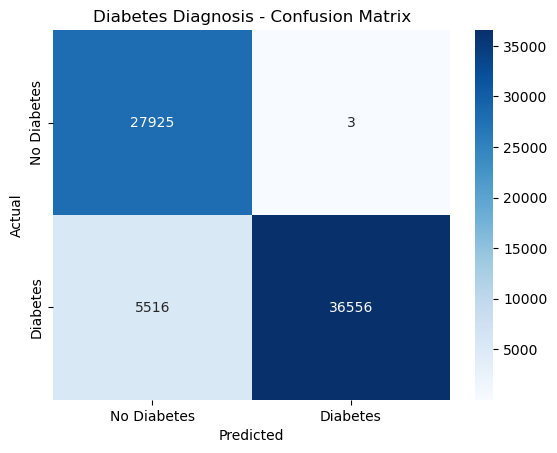

Accuracy: 0.9211571428571429
Precision: 0.999917940862715
Recall: 0.8688914242251379
F1 Score: 0.9298113975404103


Test Set Metrics:


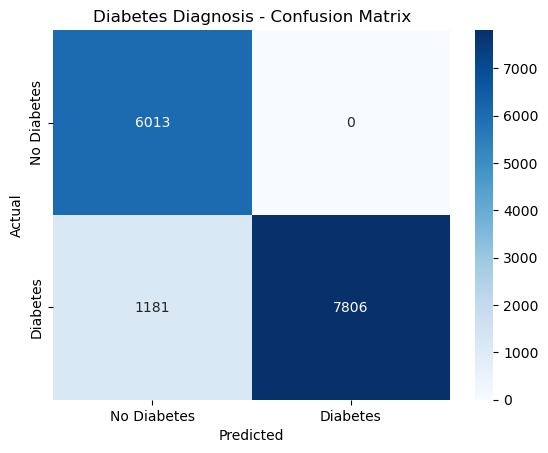

Accuracy: 0.9212666666666667
Precision: 1.0
Recall: 0.868587960387226
F1 Score: 0.9296730780682427


In [8]:
evaluate_metrics(y_train_true, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test_true, y_test_pred, "Test Set Metrics:")

XGBoost is reaching a similar f1 score to the other models. We will try to optimize the hyperparameters now.

In [9]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [200, 400, 600]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 9]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0]),
        'gamma': trial.suggest_categorical('gamma', [0, 0.1, 0.3, 0.5]),
        'min_child_weight': trial.suggest_categorical('min_child_weight', [1, 3, 5]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.5, 1, 2]),
        'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5]),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'device': 'cuda',
        'random_state': 2025
    }

    model = XGBClassifier(**params, early_stopping_rounds=50)
    model.fit(
        X_train_gpu, y_train_gpu,
        eval_set=[(X_valid_gpu, y_valid_gpu)],
        verbose=False
    )

    preds = model.predict(X_valid_gpu)
    return f1_score(y_valid, preds)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best hyperparameters found:", best_params)

[I 2025-11-12 14:53:09,980] A new study created in memory with name: no-name-9d271cbb-1eef-44fd-9551-bc4641ba489b
[I 2025-11-12 14:53:10,369] Trial 0 finished with value: 0.9287254432199329 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0}. Best is trial 0 with value: 0.9287254432199329.
[I 2025-11-12 14:53:10,643] Trial 1 finished with value: 0.9288838296087711 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.3, 'min_child_weight': 3, 'reg_lambda': 0.5, 'reg_alpha': 0.5}. Best is trial 1 with value: 0.9288838296087711.
[I 2025-11-12 14:53:11,212] Trial 2 finished with value: 0.9288838296087711 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0, 'min_child_weight': 1, 'reg_lambda': 2, 'reg_alph

Best hyperparameters found: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 3, 'reg_lambda': 1, 'reg_alpha': 0.1}


In [10]:
xgb1 = XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='logloss',
    device='cuda',
    random_state=2025,
    early_stopping_rounds=50
)

xgb1.fit(X_train_gpu, y_train_gpu, eval_set=[(X_valid_gpu, y_valid_gpu)], verbose=True)

[0]	validation_0-logloss:0.55901
[1]	validation_0-logloss:0.47821
[2]	validation_0-logloss:0.41141
[3]	validation_0-logloss:0.36361
[4]	validation_0-logloss:0.32855
[5]	validation_0-logloss:0.30269
[6]	validation_0-logloss:0.28669
[7]	validation_0-logloss:0.27416
[8]	validation_0-logloss:0.26142
[9]	validation_0-logloss:0.25166
[10]	validation_0-logloss:0.24424
[11]	validation_0-logloss:0.24011
[12]	validation_0-logloss:0.23681
[13]	validation_0-logloss:0.23235
[14]	validation_0-logloss:0.22888
[15]	validation_0-logloss:0.22613
[16]	validation_0-logloss:0.22413
[17]	validation_0-logloss:0.22234
[18]	validation_0-logloss:0.22106
[19]	validation_0-logloss:0.22014
[20]	validation_0-logloss:0.21969
[21]	validation_0-logloss:0.21881
[22]	validation_0-logloss:0.21858
[23]	validation_0-logloss:0.21803
[24]	validation_0-logloss:0.21772
[25]	validation_0-logloss:0.21736
[26]	validation_0-logloss:0.21726
[27]	validation_0-logloss:0.21710
[28]	validation_0-logloss:0.21690
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'logloss'


In [11]:
y_train_pred = xgb1.predict(X_train_gpu)
y_test_pred = xgb1.predict(X_test_gpu)

y_train_true = cp.asnumpy(y_train)
y_test_true = cp.asnumpy(y_test)

Training Set Metrics:


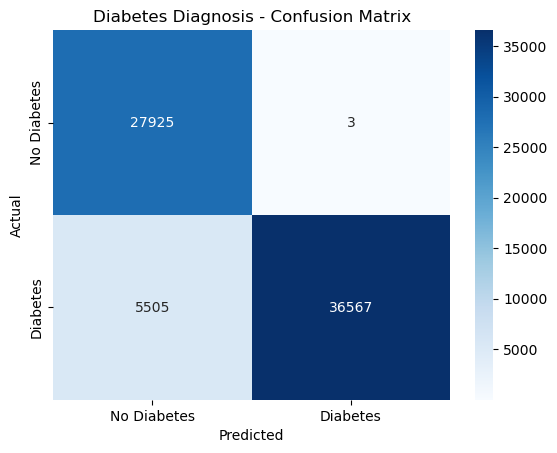

Accuracy: 0.9213142857142858
Precision: 0.9999179655455291
Recall: 0.8691528807758129
F1 Score: 0.9299610894941635


Test Set Metrics:


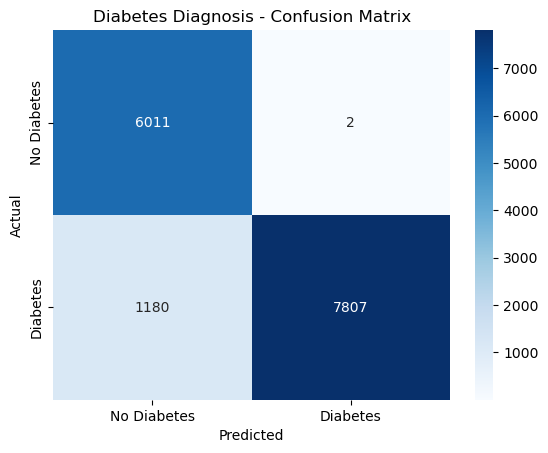

Accuracy: 0.9212
Precision: 0.9997438852605968
Recall: 0.868699232224324
F1 Score: 0.9296261014527268


In [12]:
evaluate_metrics(y_train_true, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test_true, y_test_pred, "Test Set Metrics:")

Optimizing the hyperparameters did not improve model performance. We will try to find the best threshold.

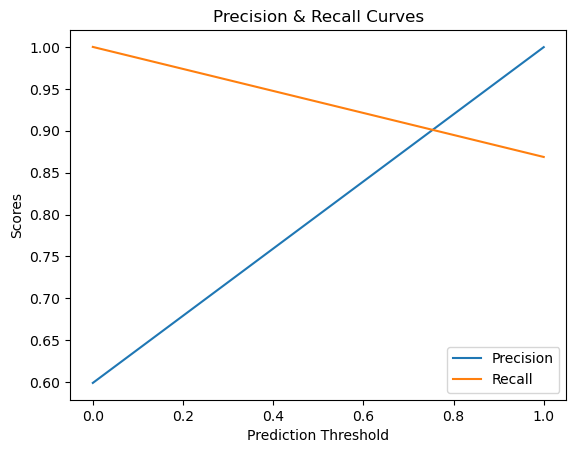

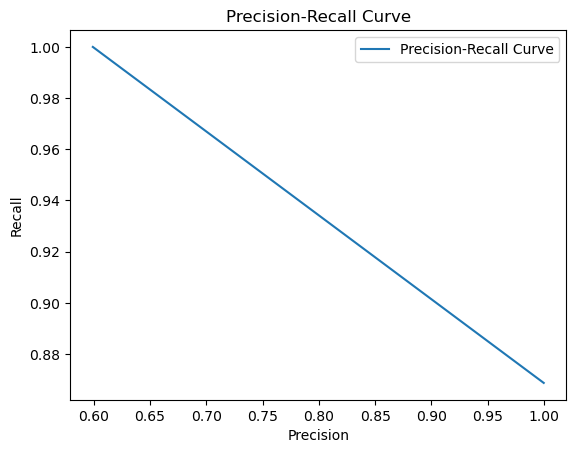

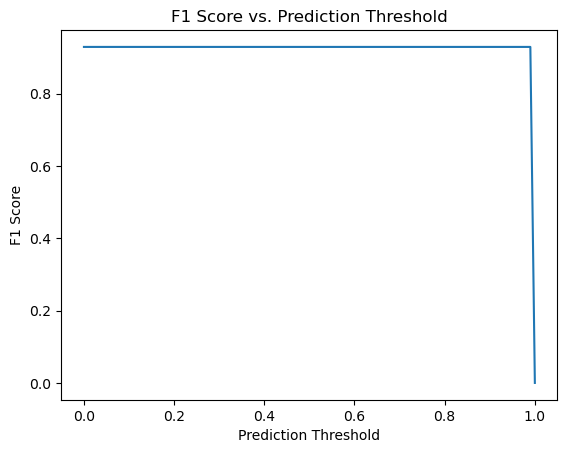

np.float64(0.0)

In [13]:
thresh = optimize_threshold(y_test_true, y_test_pred)
thresh

This likely occured due to rounding. We will test our own threshold of 0.6.

In [23]:
y_train_probs = xgb1.predict_proba(X_train_gpu)[:, 1]
y_test_probs = xgb1.predict_proba(X_test_gpu)[:, 1]

Training Set Metrics with Optimized Threshold:


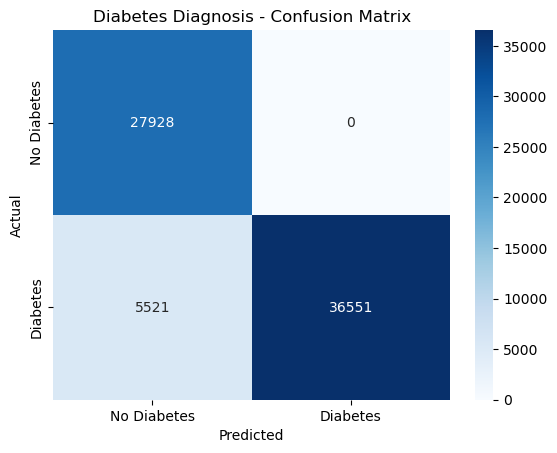

Accuracy: 0.9211285714285714
Precision: 1.0
Recall: 0.8687725803384674
F1 Score: 0.9297788179031581


Test Set Metrics with Optimized Threshold:


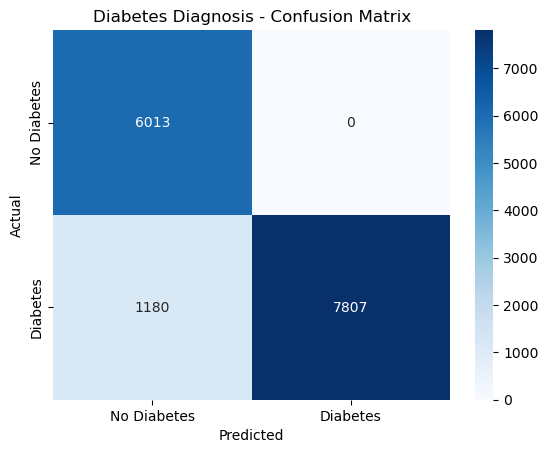

Accuracy: 0.9213333333333333
Precision: 1.0
Recall: 0.868699232224324
F1 Score: 0.9297368107657497


In [35]:
thresh = 0.6

preds_train = y_train_probs >= thresh
preds_test = y_test_probs >= thresh

evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

This model is not worth saving, so we will simply saved the untuned xgb model. Before that, we will take a quick look at feature importances, and plot the roc curve.

In [36]:
importance = xgb_untuned.get_booster().get_score(importance_type='gain')
print(importance)

{'f0': 13.698317527770996, 'f1': 4.129582405090332, 'f2': 4.311681747436523, 'f3': 4.497147560119629, 'f4': 23.71114730834961, 'f5': 3.562713623046875, 'f6': 602.1289672851562, 'f7': 3.124664068222046, 'f8': 3.152198314666748, 'f9': 4.663474082946777, 'f10': 3.37516450881958, 'f11': 3.8425233364105225, 'f12': 6.19342041015625, 'f13': 6.770766258239746, 'f14': 4.780062198638916, 'f15': 3.7798125743865967, 'f16': 4.916905879974365, 'f17': 3.7978577613830566, 'f18': 3.5486457347869873, 'f19': 3.7099008560180664, 'f20': 3.8020174503326416, 'f21': 3.5932185649871826, 'f22': 4.773281097412109, 'f23': 3.1946475505828857, 'f24': 3.3590660095214844, 'f25': 4.314824104309082, 'f26': 4.133875846862793, 'f27': 3.6885061264038086, 'f28': 4.3027496337890625, 'f29': 3.7975966930389404, 'f30': 3.801403045654297, 'f31': 3.5122220516204834, 'f32': 3.238949775695801, 'f33': 3.4660048484802246, 'f34': 2.891146183013916, 'f35': 3.4431512355804443, 'f36': 3.778757095336914, 'f37': 3.786949872970581, 'f38': 

In [37]:
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature}: {score}")

f6: 602.1289672851562
f4: 23.71114730834961
f0: 13.698317527770996
f38: 6.888402462005615
f13: 6.770766258239746
f12: 6.19342041015625
f39: 5.388792991638184
f61: 5.065404891967773
f49: 4.9561767578125
f57: 4.940456390380859
f16: 4.916905879974365
f14: 4.780062198638916
f22: 4.773281097412109
f9: 4.663474082946777
f51: 4.533555507659912
f3: 4.497147560119629
f55: 4.45467472076416
f25: 4.314824104309082
f2: 4.311681747436523
f28: 4.3027496337890625
f69: 4.277447700500488
f66: 4.240813255310059
f48: 4.192084789276123
f67: 4.148447513580322
f26: 4.133875846862793
f52: 4.131918430328369
f1: 4.129582405090332
f50: 4.089028835296631
f65: 4.078413486480713
f43: 4.0740885734558105
f68: 3.9923338890075684
f56: 3.9803173542022705
f53: 3.963527202606201
f58: 3.8550939559936523
f11: 3.8425233364105225
f20: 3.8020174503326416
f30: 3.801403045654297
f42: 3.7993791103363037
f17: 3.7978577613830566
f29: 3.7975966930389404
f37: 3.786949872970581
f15: 3.7798125743865967
f36: 3.778757095336914
f54: 3.747

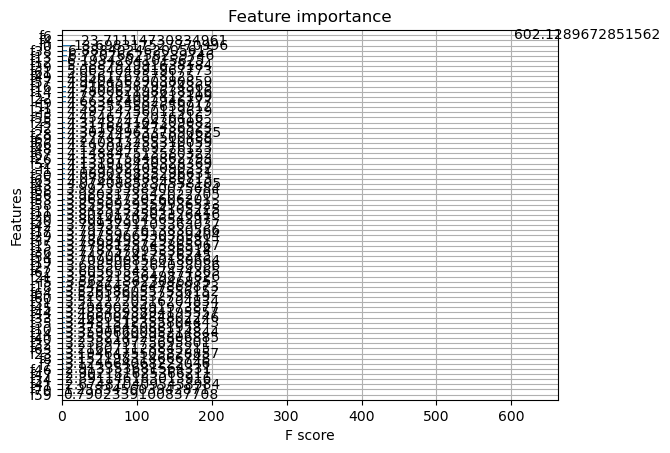

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_untuned, importance_type='gain')
plt.show()


In [41]:
df.columns[6]

'hba1c'

We are starting to notice a clear pattern. Hba1c is by far the most influential factor in all of the models we have tried thus far. We will try to train a model that only takes that one factor into account and see how it performs. First, let us plot the roc curve for the existing untuned xgb model.

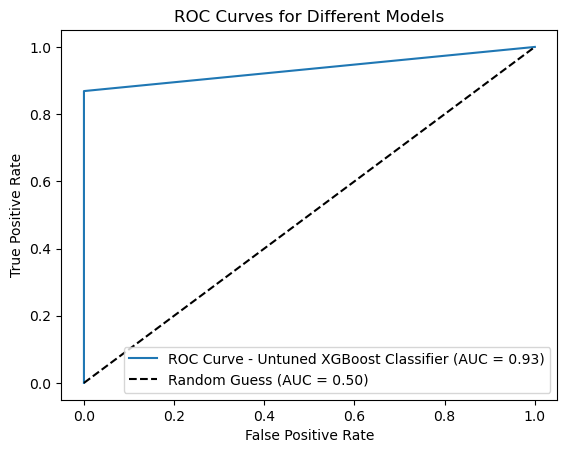

In [44]:
y_test_pred = xgb_untuned.predict(X_test_gpu)
plot_roc_curve(y_test_true, y_test_pred, "ROC Curve - Untuned XGBoost Classifier")

In [46]:
df_simplified = df[['hba1c', 'diagnosed_diabetes']]
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(df_simplified)

In [47]:
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_valid_gpu = cp.array(X_valid)
y_valid_gpu = cp.array(y_valid)
X_test_gpu  = cp.array(X_test)
y_test_gpu  = cp.array(y_test)

In [48]:
xgb_untuned_2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    device='cuda',
    early_stopping_rounds=50,
    random_state=2025
)

xgb_untuned_2.fit(
    X_train_gpu, y_train_gpu,
    eval_set=[(X_valid_gpu, y_valid_gpu)],
    verbose=None
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'logloss'


In [50]:
y_train_pred = xgb_untuned_2.predict(X_train_gpu)
y_test_pred = xgb_untuned_2.predict(X_test_gpu)

y_train_true = cp.asnumpy(y_train)
y_test_true = cp.asnumpy(y_test)

Training Set Metrics:


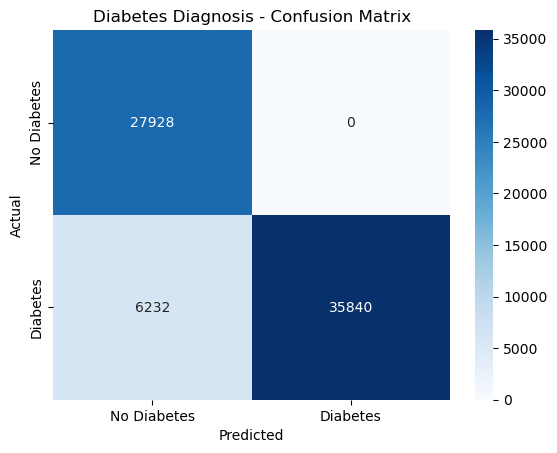

Accuracy: 0.9109714285714285
Precision: 1.0
Recall: 0.8518729796539266
F1 Score: 0.9200123215935928


Test Set Metrics:


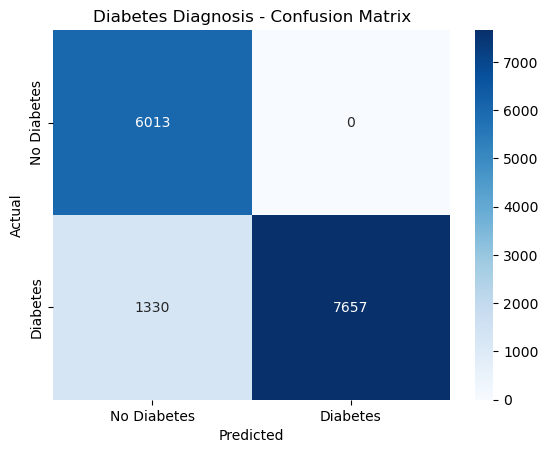

Accuracy: 0.9113333333333333
Precision: 1.0
Recall: 0.8520084566596194
F1 Score: 0.9200913242009132


In [51]:
evaluate_metrics(y_train_true, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test_true, y_test_pred, "Test Set Metrics:")

This model performs almost as well as the one with over 70 columns. We will try to add two more features to maximize its performance while keeping it simple.

In [52]:
df.columns[[0, 4]]

Index(['family_history_diabetes', 'glucose_fasting'], dtype='object')

In [53]:
df_simplified_2 = df[['hba1c', 'glucose_fasting', "family_history_diabetes", 'diagnosed_diabetes']]

In [54]:
df_simplified_2 = df[['hba1c', 'diagnosed_diabetes']]
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(df_simplified_2)

In [55]:
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)
X_valid_gpu = cp.array(X_valid)
y_valid_gpu = cp.array(y_valid)
X_test_gpu  = cp.array(X_test)
y_test_gpu  = cp.array(y_test)

In [56]:
xgb_untuned_3 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    device='cuda',
    early_stopping_rounds=50,
    random_state=2025
)

xgb_untuned_3.fit(
    X_train_gpu, y_train_gpu,
    eval_set=[(X_valid_gpu, y_valid_gpu)],
    verbose=None
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'logloss'


In [57]:
y_train_pred = xgb_untuned_3.predict(X_train_gpu)
y_test_pred = xgb_untuned_3.predict(X_test_gpu)

y_train_true = cp.asnumpy(y_train)
y_test_true = cp.asnumpy(y_test)

Training Set Metrics:


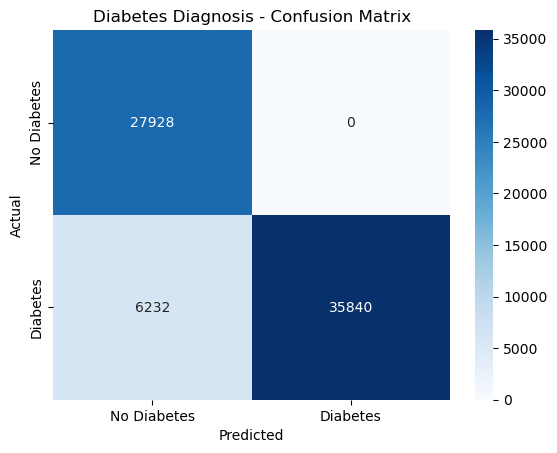

Accuracy: 0.9109714285714285
Precision: 1.0
Recall: 0.8518729796539266
F1 Score: 0.9200123215935928


Test Set Metrics:


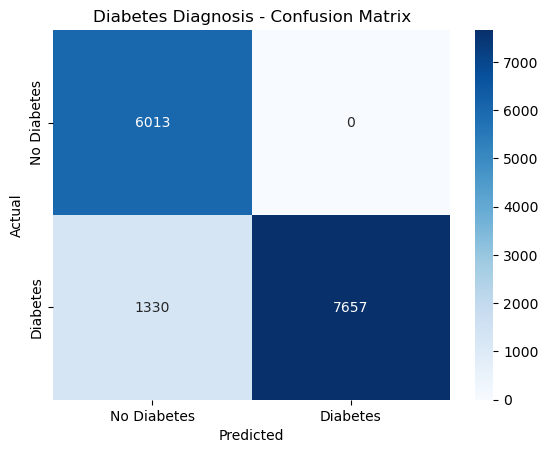

Accuracy: 0.9113333333333333
Precision: 1.0
Recall: 0.8520084566596194
F1 Score: 0.9200913242009132


In [58]:
evaluate_metrics(y_train_true, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test_true, y_test_pred, "Test Set Metrics:")

These two features did not improve our model by much. We will plot the roc curve of the xgb_untuned_2 model to see if the performance drop is really significant.

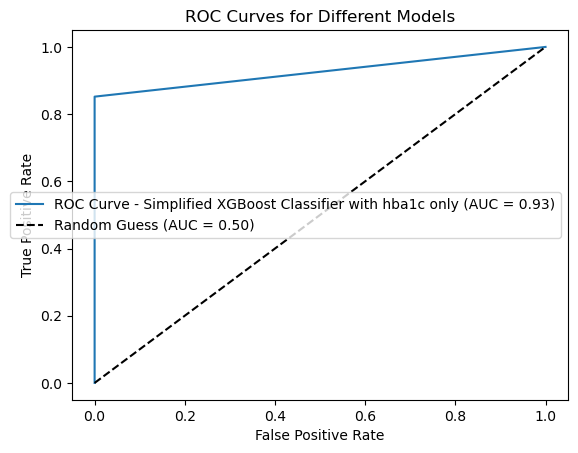

In [63]:
y_test_pred = xgb_untuned_2.predict(X_test_gpu)
plot_roc_curve(y_test_true, y_test_pred, "ROC Curve - Simplified XGBoost Classifier with hba1c only")

The ROC curve looks promising. This model is incredibly simple, while providing us with the same kind of performance as much of the more complex ones. Let us just try to find a better threshold.

In [64]:
y_train_pred = xgb_untuned_2.predict(X_train_gpu)

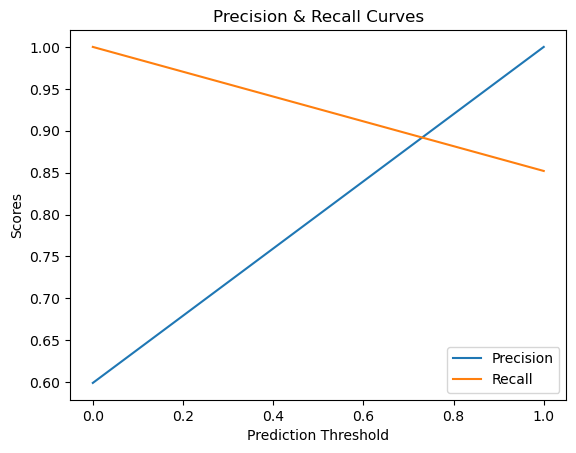

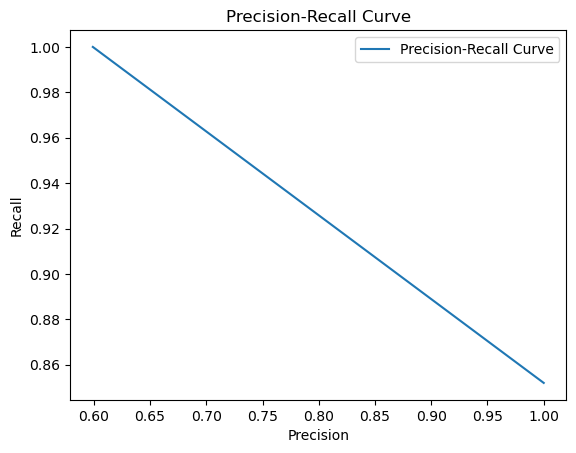

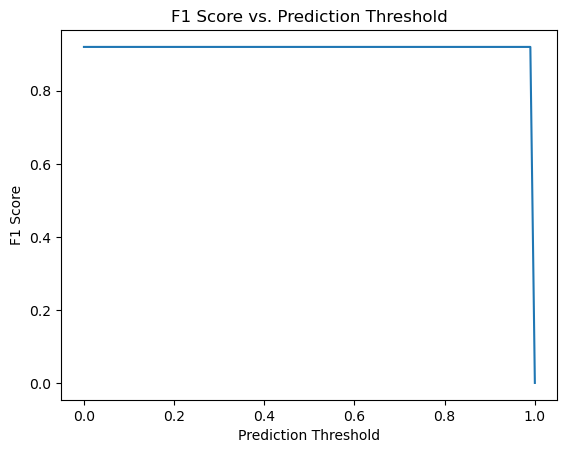

np.float64(0.0)

In [65]:
thresh = optimize_threshold(y_test_true, y_test_pred)
thresh

This model cannot be optimized any further, so we will save it.

In [66]:
joblib.dump(xgb_untuned_2, "../models/xgboost_model.joblib")

['../models/xgboost_model.joblib']